In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
import ast
import re
from itertools import combinations

In [43]:
import numpy as np

In [2]:
df = pd.read_csv('datasets/paragraphes_clauses_set.csv')

In [3]:
dataset = df[['id', 'doc_id', 'clause_text', 'categories_set']]
dataset.head()

,id,doc_id,clause_text,categories_set
0,PAIR_00000001,DOC_0001,EXHIBIT 10.6 DISTRIBUTOR AGREEMENT THIS DISTRI...,{'Document Name'}
1,PAIR_00000018,DOC_0001,D. The Company's Appointment. The Company appo...,{'Exclusivity'}
2,PAIR_00000017,DOC_0001,1.3 Term. The term of this Agreement shall be ...,"{'Renewal Term', 'License Grant', 'Exclusivity..."
3,PAIR_00000037,DOC_0001,On the commencement of the Term Distributor wi...,{'Minimum Commitment'}
4,PAIR_00000036,DOC_0001,"(H) 2,856 unit each in the lat three years of ...",{'Minimum Commitment'}


In [4]:
dataset.shape[0]

7073

In [5]:
dataset.shape

(7073, 4)

In [24]:
from collections import Counter
counter = Counter(cat for cats in dataset["categories_set"] for cat in cats)

In [25]:
print(counter)

Counter({'no-risk': 1759, 'Parties': 712, 'License Grant': 536, 'Anti-Assignment': 476, 'Document Name': 467, 'Cap On Liability': 449, 'Governing Law': 446, 'Expiration Date': 436, 'Agreement Date': 403, 'Effective Date': 387, 'Audit Rights': 384, 'Post-Termination Services': 337, 'Minimum Commitment': 316, 'Exclusivity': 297, 'Revenue/Profit Sharing': 284, 'Insurance': 242, 'Non-Transferable License': 216, 'Termination For Convenience': 204, 'Ip Ownership Assignment': 200, 'Non-Compete': 195, 'Change Of Control': 185, 'Renewal Term': 181, 'Rofr/Rofo/Rofn': 143, 'Covenant Not To Sue': 138, 'Uncapped Liability': 125, 'Irrevocable Or Perpetual License': 121, 'Volume Restriction': 120, 'Warranty Duration': 115, 'Notice Period To Terminate Renewal': 111, 'Competitive Restriction Exception': 98, 'Affiliate License-Licensee': 89, 'Liquidated Damages': 83, 'Joint Ip Ownership': 78, 'No-Solicit Of Employees': 70, 'No-Solicit Of Customers': 48, 'Non-Disparagement': 48, 'Affiliate License-Licens

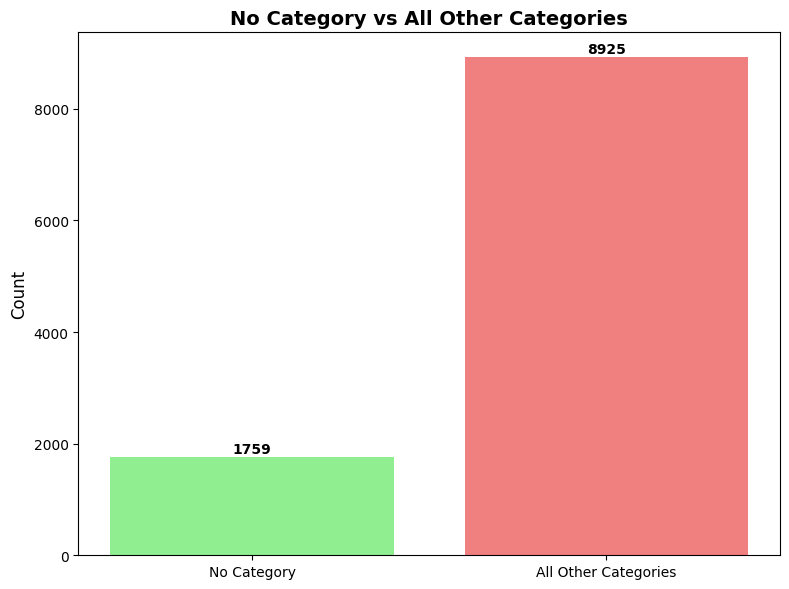

In [35]:

no_risk_count = counter['no-risk']
other_categories = sum(counter.values()) - no_risk_count

# Create the comparison data
comparison_data = {
    'No Category': no_risk_count,
    'All Other Categories': other_categories
}

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(comparison_data.keys(), comparison_data.values(), 
               color=['lightgreen', 'lightcoral'])

plt.title('No Category vs All Other Categories', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/1_no_category_vs_others.png')  
plt.show() 

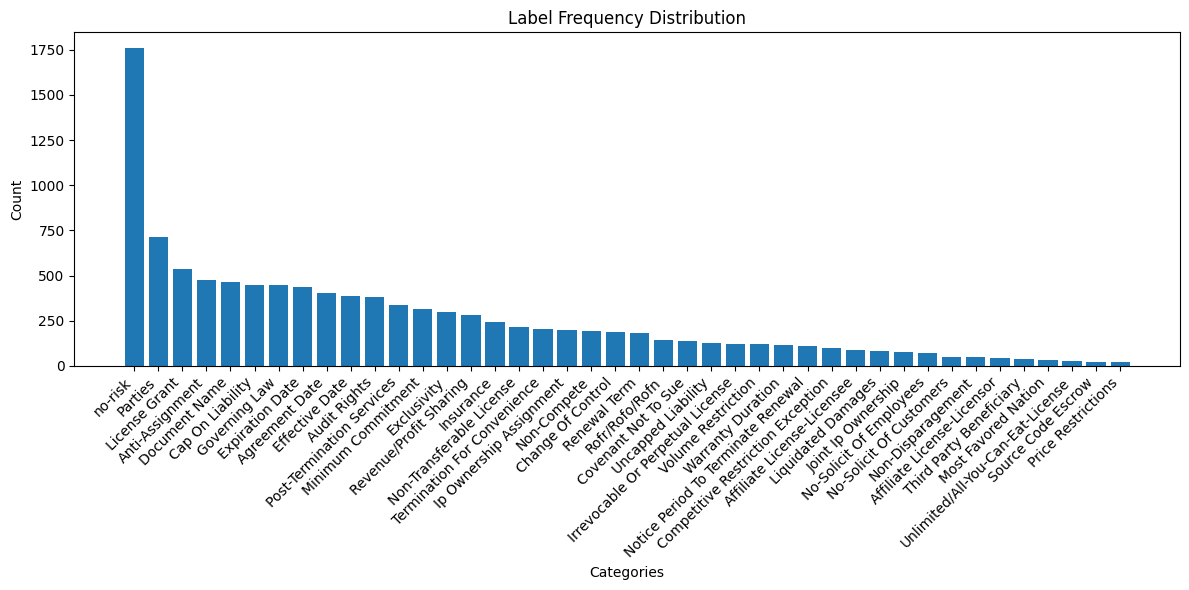

In [45]:
sorted_counter = counter.most_common()

plt.figure(figsize=(12, 6))
plt.bar([item[0] for item in sorted_counter], [item[1] for item in sorted_counter])
plt.title('Label Frequency Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/2_category_counts_bar_chart.png') 
plt.show()

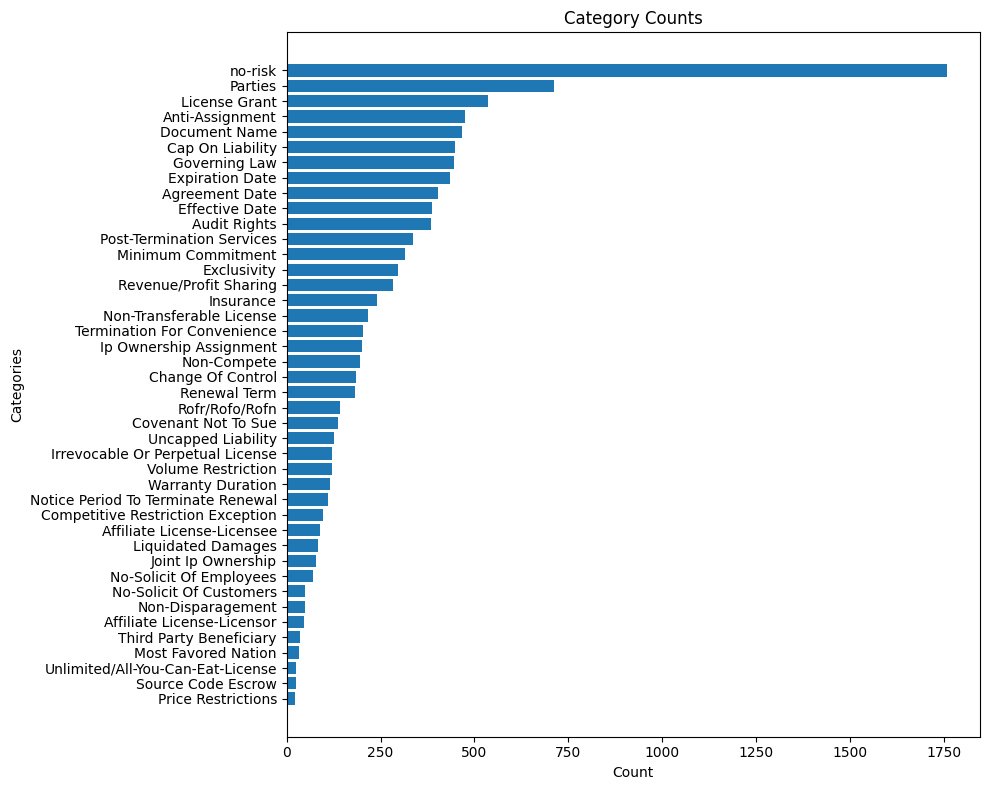

In [42]:
sorted_counter = counter.most_common()

plt.figure(figsize=(10, 8))
# Reverse the order to have highest value at the top
plt.barh([item[0] for item in reversed(sorted_counter)], 
         [item[1] for item in reversed(sorted_counter)])
plt.title('Category Counts')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.tight_layout()
plt.savefig('visualizations/2_category_counts_horizontal_bar_chart.png') 
plt.show()

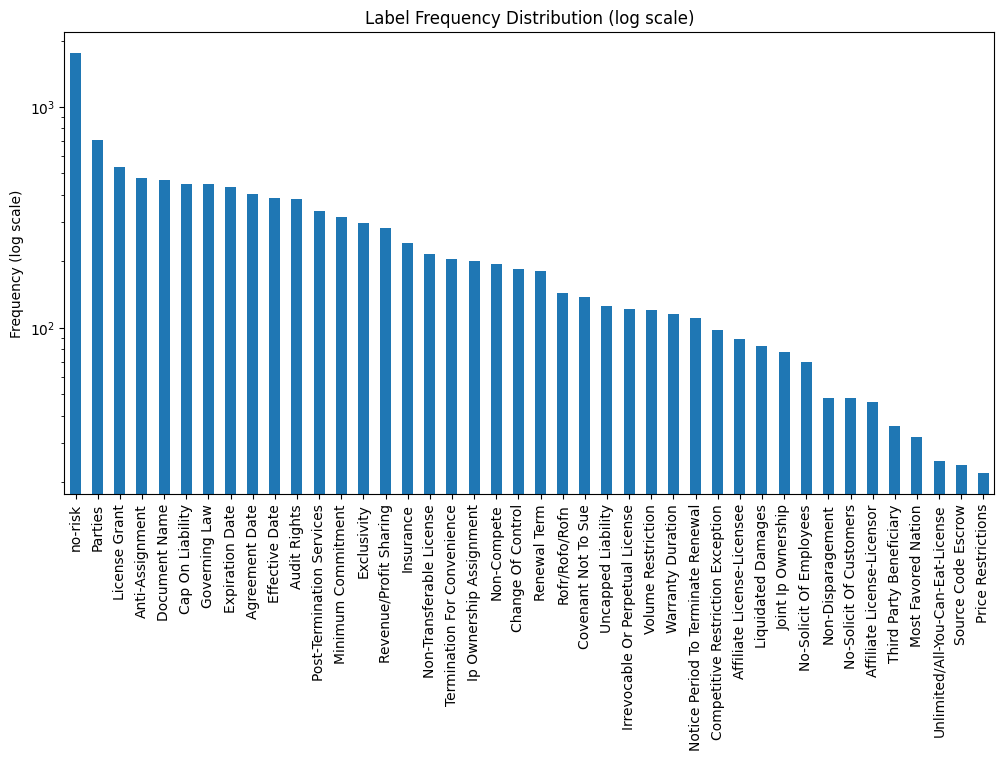

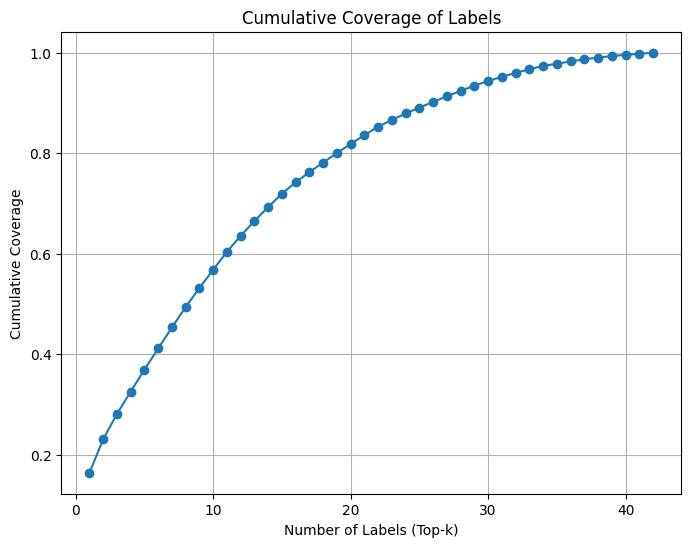

In [46]:
# Flatten categories_set into a list of labels
all_labels = [label for cats in dataset["categories_set"] for label in cats]

# Count frequencies
label_counts = Counter(all_labels)
label_freq = pd.Series(label_counts).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_freq.plot(kind="bar")
plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.title("Label Frequency Distribution (log scale)")
plt.savefig('visualizations/3_label_frequency_log_scale.png') 
plt.show()


cum_counts = label_freq.cumsum()
coverage = cum_counts / cum_counts.iloc[-1]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker="o")
plt.xlabel("Number of Labels (Top-k)")
plt.ylabel("Cumulative Coverage")
plt.title("Cumulative Coverage of Labels")
plt.grid(True)
plt.savefig('visualizations/4_cumulative_coverage_of_lables.png')
plt.show()

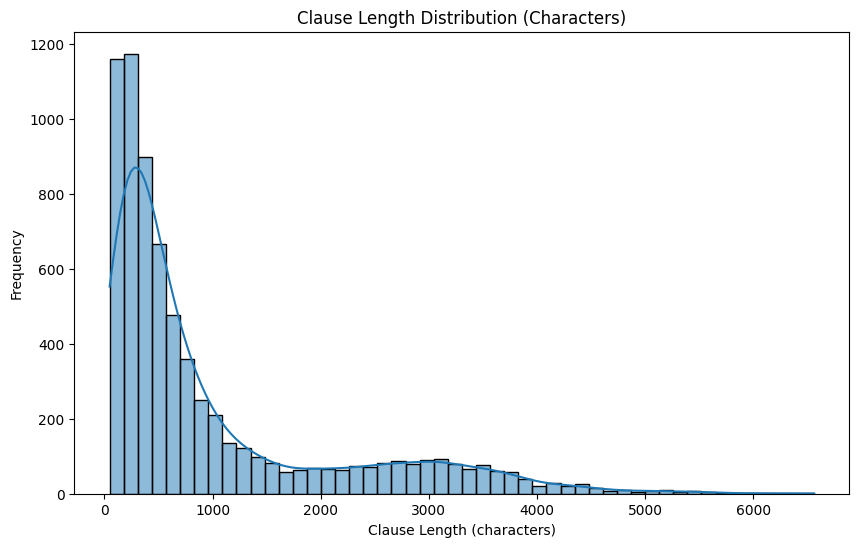

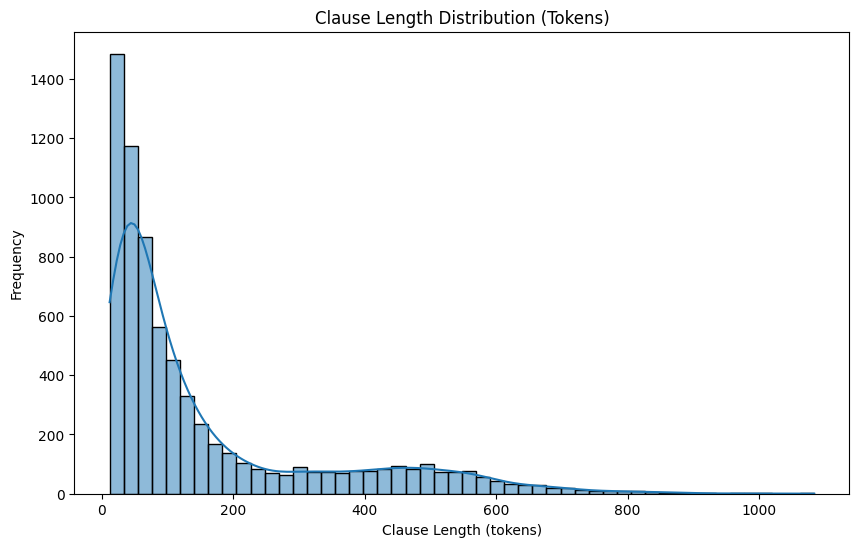

In [48]:
# Clause lengths
df["clause_char_len"] = df["clause_text"].str.len()
df["clause_token_len"] = df["clause_text"].str.split().apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df["clause_char_len"], bins=50, kde=True)
plt.xlabel("Clause Length (characters)")
plt.ylabel("Frequency")
plt.title("Clause Length Distribution (Characters)")
plt.savefig('visualizations/5_clause_length_in_characters.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df["clause_token_len"], bins=50, kde=True)
plt.xlabel("Clause Length (tokens)")
plt.ylabel("Frequency")
plt.title("Clause Length Distribution (Tokens)")
plt.savefig('visualizations/6_clause_length_in_tokens.png')
plt.show()

In [51]:
# Defensive parser for categories_set that may be a set/list or a string
def parse_categories(value):
    """
    Returns a cleaned list of unique category strings for a row.
    Handles:
      - actual Python set/list/tuple
      - string representations like "{'A', 'B'}" or "['A','B']"
      - plain comma-separated strings
      - NaN / None
    """
    if pd.isna(value):
        return []

    # If it's already a set/list/tuple -> convert to list
    if isinstance(value, (set, list, tuple)):
        items = list(value)
    elif isinstance(value, str):
        s = value.strip()
        # Try literal eval first (safe for Python literal structures)
        try:
            lit = ast.literal_eval(s)
            if isinstance(lit, (list, tuple, set)):
                items = list(lit)
            else:
                # single literal (string/number)
                items = [lit] if lit != '' else []
        except Exception:
            # Fallback: remove surrounding braces/brackets and split by commas
            # Remove outer braces/brackets if present
            if (s.startswith("{") and s.endswith("}")) or (s.startswith("(") and s.endswith(")")) or (s.startswith("[") and s.endswith("]")):
                s_inner = s[1:-1]
            else:
                s_inner = s

            # Split on commas that are not inside braces (simple split is fine here)
            parts = [p.strip() for p in s_inner.split(",") if p.strip()]

            # Strip surrounding quotes for each part
            items = [re.sub(r"^['\"]|['\"]$", "", p).strip() for p in parts if p != ""]
    else:
        # Any other type -> coerce to string
        items = [str(value)]

    # Final cleanup: remove empty strings / None, preserve order, make unique
    cleaned = []
    seen = set()
    for it in items:
        if it is None:
            continue
        it = str(it).strip()
        if it == "":
            continue
        if it not in seen:
            cleaned.append(it)
            seen.add(it)
    return cleaned


In [59]:
df["categories_list"] = df["categories_set"].apply(parse_categories)

# Convert to set and compute num_labels (unique count)
df["num_labels"] = df["categories_list"].apply(lambda lst: len(set(lst)))

# Check any rows > 42 (should be 0)
anomalies = df[df["num_labels"] > 42]
print("Number of anomalous rows with >42 labels:", len(anomalies))
if len(anomalies) > 0:
    # show a small sample for debugging
    display(anomalies.loc[:, ["sample_id", "doc_id", "categories_set", "categories_list", "num_labels"]].head(20))


Number of anomalous rows with >42 labels: 0


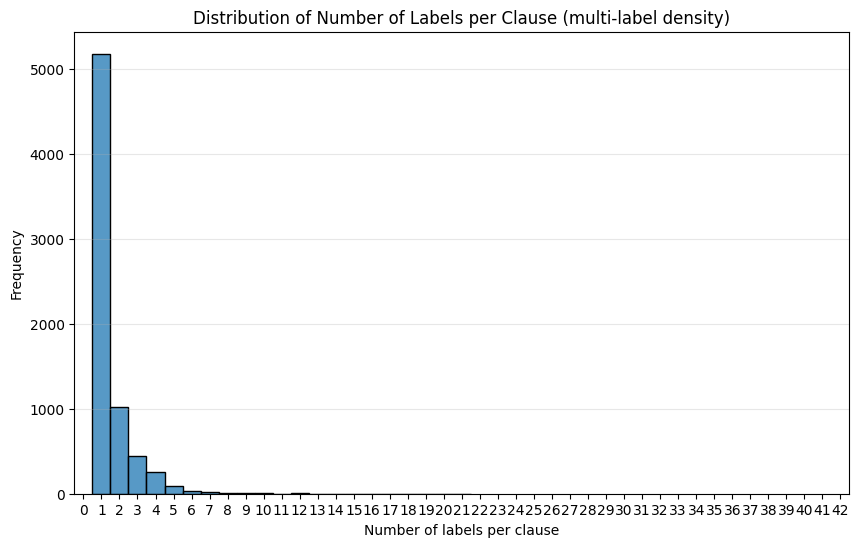

In [60]:

plt.figure(figsize=(10, 6))
bins = range(0, 43)  # 0..42
sns.histplot(df["num_labels"], bins=bins, discrete=True)
plt.xlabel("Number of labels per clause")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Labels per Clause (multi-label density)")
plt.xlim(-0.5, 42 + 0.5)
plt.xticks(range(0, 43))
plt.grid(axis="y", alpha=0.3)
plt.savefig('visualizations/7_labels_per_clause.png')
plt.show()